# Algorithms for Table 2

This Jypyter Notebook takes the second table, and produces optimal machine learning algorithms on it. That is, it takes patients that from the first table, complete with their classification. Then, from the easiest level of the game that they have been assigned to (Easy1, Medium1, or Hard1, depending on their classification from table 1), outputs a number 1-5. The number, complete with the classification from table1, outputs a the precise level of difficulty at which a patient should start. For instance, if table 1 outputs Easy, and table2 outputs 3, the patient should start the rehabilitation process at game difficulty level Easy3.

## Data Preprocessing

First, as before, we import the necessary packages, load them into a pandas DataFrame, and display a sample of the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings(action = 'ignore')
# ignoring warnings, to make the results simpler to read

In [3]:
new = pd.read_excel('Data2.xlsx', sheet_name = 'Table 2 - Games')

In [4]:
new.set_index('Patient No. (ID)', inplace=True)

In [5]:
new.sample(10)

,Difficulty,Total time taken (s),% targets hit,Average hit time (s) (for successful hits),# Possible Targets,Targets hit,Time per target / overall,Output
Patient No. (ID),,,,,,,,
18,Easy,109.4,0.800000,6.3,10,8,13.675000,4
42,Medium,168.0,0.818182,3.5,22,18,9.333333,4
72,Hard,154.6,0.968750,1.6,32,31,4.987097,5
45,Medium,162.6,0.818182,3.2,22,18,9.033333,4
27,Medium,233.2,0.636364,6.3,22,14,16.657143,1
24,Easy,88.0,1.000000,5.9,10,10,8.800000,5
10,Easy,131.6,0.600000,7.1,10,6,21.933333,2
28,Medium,229.0,0.636364,6.0,22,14,16.357143,1
22,Easy,97.1,0.900000,5.9,10,9,10.788889,5


A few columns were used only for calculating the total time taken, and % targets hit, and so these can be removed. The numerical columns are also rounded to an appropriate number of decimal places, in order to reduce the extent of overfitting on values with higher degrees of precision. We do not wish to overfit values that are based on several decimal places, especailly when the values were created by the clinet. Rounding is therefore both appropriate and necessary. We also rename the columns for easier referencing.

In [6]:
new.drop(['# Possible Targets', 'Targets hit', 'Time per target / overall'], axis=1, inplace=True)

In [7]:
new.rename(columns={'Average hit time (s) (for successful hits)': 'Average hit time', 'Total time taken (s)': 'Time taken'}, inplace=True)

In [8]:
new = new.round({'Time taken' : 0, '% targets hit': 2, 'Average hit time' : 1})
new.sample(5)

,Difficulty,Time taken,% targets hit,Average hit time,Output
Patient No. (ID),,,,,
74,Hard,140.0,1.00,1.4,5
64,Hard,202.0,0.88,2.4,3
52,Hard,281.0,0.66,3.6,1
65,Hard,199.0,0.88,2.3,3
40,Medium,180.0,0.77,3.8,3


## Data Visualisation

Next, we beginning plotting our input data. We firstly look at the spread of input features.

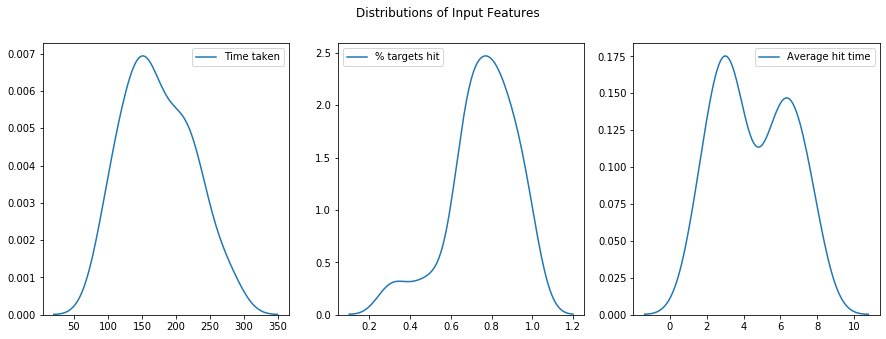

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of Input Features')
sns.kdeplot(new['Time taken'], ax=axes[0])
sns.kdeplot(new['% targets hit'], ax=axes[1])
sns.kdeplot(new['Average hit time'], ax=axes[2])

Time taken is relatively symmetrical, with harder difficulties or weaker patients requiring more time to complete levels. There is a relatively strong negative skew in the percentage of targets hit, making it simpler to classifiy a patient into difficulty levels 1 and 2, but harder for 3 and 4. Average hit time has multiple peaks, similar to the distributions seen from Table1. We next plot violin spreads across difficulty inputs.

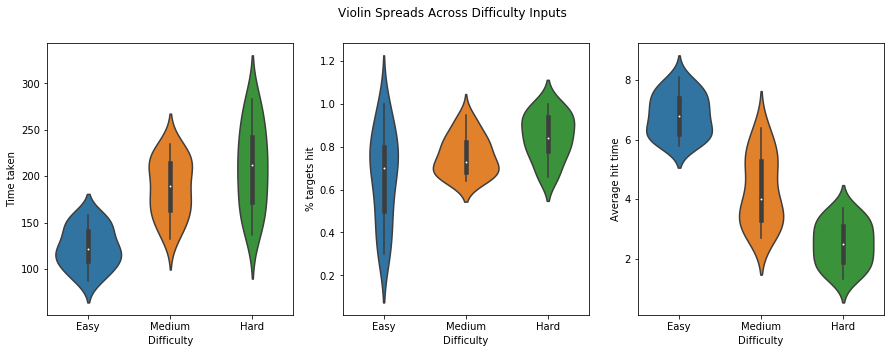

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Violin Spreads Across Difficulty Inputs')
columns = ['Time taken', '% targets hit', 'Average hit time']
for i, p in enumerate(columns):
    sns.violinplot(
        x='Difficulty',
        y=p,
        data=new,
        ax=axes[i]
    )

There is a noticable difference in average hit time between the three difficulty inputs, where patients that have been assigned to Hard hit the targets, when successful, much more quickly. The other two plots may seem surprising, until it is stated that easy difficulty has more targets to hit, at harder locations to reach. This is why total time taken increases with difficulty, and why % targets hit has a relatively consistent median across difficulty inputs. We next visualise the correlation between the intput variables.

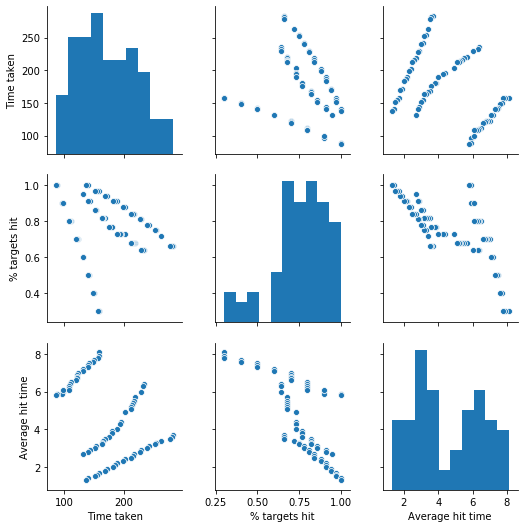

In [11]:
sns.pairplot(new[['Time taken', '% targets hit', 'Average hit time']])

Like in table 1, there is some correlation between the input variables. This is especially true for the relationship between Average hit time, and total time taken, which will be analysed in more detail below. Further, we can see the spread of results for patients of each difficulty level (Easy, Medium, and Hard). Such differences, and the results from the violin plots, mean we will need to separate the data into three distinct tables.

Because the values for the input variables differ for difficulty levels, it is important to separate this data into three distinct tables. This is because, for example, what makes the algorithm output a 5 for a patient playing an Easy game will be significantly different from what makes the algorithm output a 5 for a Medium difficulty. In order to achieve consistency, three sub-tables are created.

In [12]:
easy_filter = new['Difficulty'] == 'Easy'
easy = new[easy_filter]
easy.sample(5)

,Difficulty,Time taken,% targets hit,Average hit time,Output
Patient No. (ID),,,,,
19,Easy,109.0,0.8,6.2,4
1,Easy,158.0,0.3,8.1,1
18,Easy,109.0,0.8,6.3,4
16,Easy,111.0,0.8,6.5,4
10,Easy,132.0,0.6,7.1,2


In [13]:
medium_filter = new['Difficulty'] == 'Medium'
medium = new[medium_filter]
medium.sample(5)

,Difficulty,Time taken,% targets hit,Average hit time,Output
Patient No. (ID),,,,,
27,Medium,233.0,0.64,6.3,1
38,Medium,189.0,0.73,4.0,3
26,Medium,235.0,0.64,6.4,1
36,Medium,195.0,0.73,4.4,3
49,Medium,141.0,0.91,2.8,5


In [14]:
hard_filter = new['Difficulty'] == 'Hard'
hard = new[hard_filter]
hard.sample(5)

,Difficulty,Time taken,% targets hit,Average hit time,Output
Patient No. (ID),,,,,
60,Hard,228.0,0.81,2.8,2
55,Hard,254.0,0.75,3.3,1
65,Hard,199.0,0.88,2.3,3
61,Hard,218.0,0.84,2.7,3
72,Hard,155.0,0.97,1.6,5


And the 'Difficulty' column is removed from each.

In [15]:
easy.drop(['Difficulty'], axis=1, inplace=True)
medium.drop(['Difficulty'], axis=1, inplace=True)
hard.drop(['Difficulty'], axis=1, inplace=True)

In [16]:
medium.sample(5)

,Time taken,% targets hit,Average hit time,Output
Patient No. (ID),,,,
42,168.0,0.82,3.5,4
38,189.0,0.73,4.0,3
39,181.0,0.77,3.9,3
48,143.0,0.91,2.9,5
49,141.0,0.91,2.8,5


With the data separated, and since there are three inputs in the algorithm, it is possible to create 3D plots of the inputs, with the hue of the scatter points representing the output level, for our three different tables. We therefore create three 3D plots, one for each of the tables created. Each plot visually identifies which points are assigned to each of the five classes.

In [17]:
from mpl_toolkits import mplot3d
def create3dplot(dif, name): 

    colours = ['b', 'c', 'y', 'm', 'r']
    fig = plt.figure(figsize=(10,8))
    fig.suptitle(f'3D Scatter Points in {name}')
    ax = plt.subplot(111, projection='3d')
    one = dif[dif['Output'] == 1]
    two = dif[dif['Output'] == 2]
    three = dif[dif['Output'] == 3]
    four = dif[dif['Output'] == 4]
    five = dif[dif['Output'] == 5]
    
    xs = [one['% targets hit'], two['% targets hit'], three['% targets hit'], four['% targets hit'], five['% targets hit']]
    ys = [one['Time taken'], two['Time taken'], three['Time taken'], four['Time taken'], five['Time taken']]
    zs = [one['Average hit time'], two['Average hit time'], three['Average hit time'], four['Average hit time'], five['Average hit time']]
    
    for i in range(5):
        ax.plot(xs[i], ys[i], zs[i], 'o', color=colours[i], label=i+1)

    ax.set_xlabel('% targets hit')
    ax.set_ylabel('Time taken')
    ax.set_zlabel('Average hit time')

    plt.legend()
# bbox_to_anchor=(0,0)

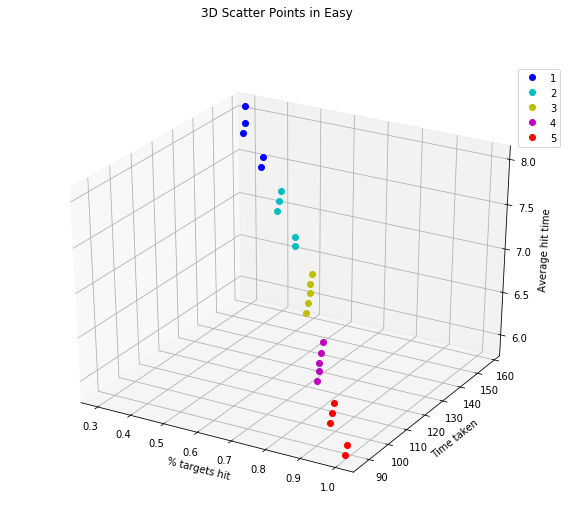

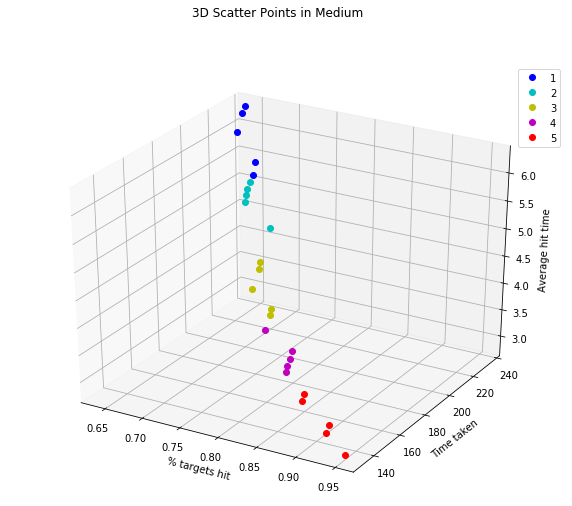

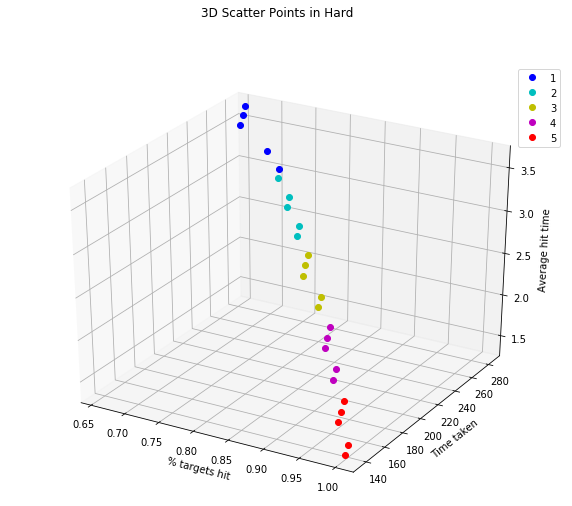

In [18]:
create3dplot(easy, 'Easy')
create3dplot(medium, 'Medium')
create3dplot(hard, 'Hard')

What we notice here is that the Easy table appears very easy to classify, with points that are easily distinguishable. For Medium and Hard this is also mostly true, and a machine learning algorithm should easily classify the points with a high degree of accuracy. This means that the machine learning algorithms, in principle, should be able to distinghuish between the classes with high accuracy. In order to examine these plots further, we decompose this 3D plot into three separate 2D plots, each plotting each pair of inputs against each other for the Hard difficulty. From this, we will be able to see if data contains any outliers, or misclassified points.

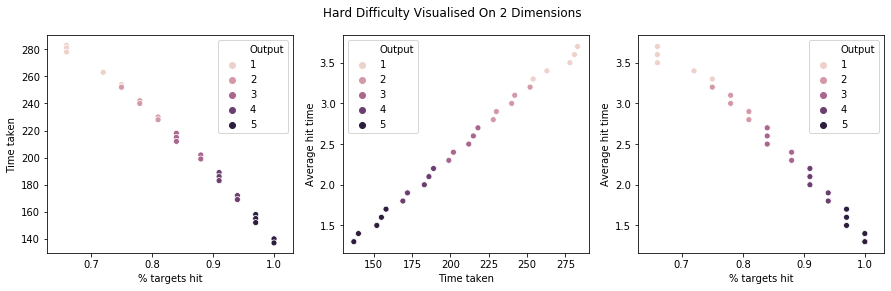

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Hard Difficulty Visualised On 2 Dimensions')
sns.scatterplot(x=hard['% targets hit'], y=hard['Time taken'], hue=hard['Output'], legend='full', ax=axes[0])
sns.scatterplot(x=hard['Time taken'], y=hard['Average hit time'], hue=hard['Output'], legend='full', ax=axes[1])
sns.scatterplot(x=hard['% targets hit'], y=hard['Average hit time'], hue=hard['Output'], legend='full', ax=axes[2])

Viewing these results on three-separate 2D graphs on more detail, the results to appear ver consistent, with no clear outlier spanning all three 2D plots. Viewing the results in this way is important, as it shows is that the data we are working with is consistent and unbiased.

We can also construct violin plots to see whether there is much difference between the input variables, for a given difficulty level, on different values of output. If there are, it will make the classification task simplier. We will look at only the Medium table here, but similar results will apply to all three tables.

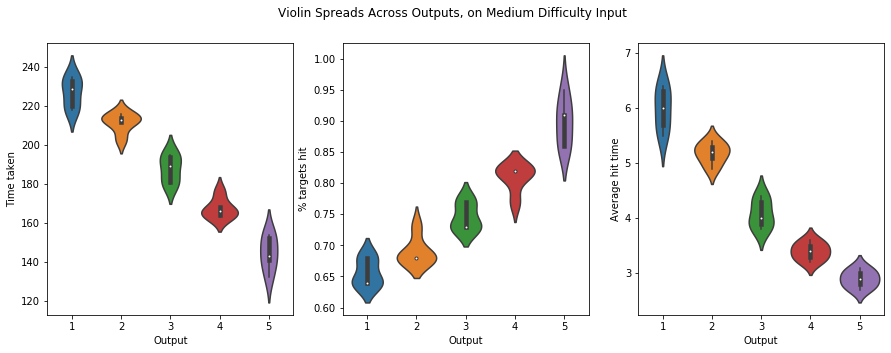

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Violin Spreads Across Outputs, on Medium Difficulty Input')
columns = ['Time taken', '% targets hit', 'Average hit time']
for i, p in enumerate(columns):
    sns.violinplot(
        x='Output',
        y=p,
        data=medium,
        ax=axes[i]
    )

Here, we can clearly see that the spread the data between different outputs, with higher difficulty outputs having a lower time taken, greater percentage of targets hit, and a lower average hit time. This will make training the algorithms simpler.

We, in addition, need to split into training and testing data. However, because we have 3 different tables this time, we need to create 12 different variables: X_train, X_test, y_train, and y_test for each of the Easy, Medium, and Hard tables.

In [21]:
from sklearn.model_selection import train_test_split
X_easy = easy.drop(columns=['Output'])
y_easy = easy.Output
X_train_easy, X_test_easy, y_train_easy, y_test_easy = train_test_split(X_easy, y_easy, test_size=0.2, random_state=13)

X_medium = medium.drop(columns=['Output'])
y_medium = medium.Output
X_train_medium, X_test_medium, y_train_medium, y_test_medium = train_test_split(X_medium, y_medium, test_size=0.2, random_state=13)

X_hard = hard.drop(columns=['Output'])
y_hard = hard.Output
X_train_hard, X_test_hard, y_train_hard, y_test_hard = train_test_split(X_hard, y_hard, test_size=0.2, random_state=13)

In [22]:
X_train_easy.sample(5)

,Time taken,% targets hit,Average hit time
Patient No. (ID),,,
5,149.0,0.4,7.6
10,132.0,0.6,7.1
22,97.0,0.9,5.9
17,110.0,0.8,6.4
24,88.0,1.0,5.9


In [23]:
y_train_easy.sample(5)

Patient No. (ID)
7     2
3     1
1     1
19    4
20    4
Name: Output, dtype: int64

## Classification

Because we have three different tables this time, we need to run GridSearchCV three different times. The results are combined and displayed for each difficulty.

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [25]:
parameters_RFC = {'n_estimators': [4, 6, 9], 
                  'max_features': ['log2', 'sqrt','auto'], 
                  'criterion': ['entropy', 'gini'],
                  'max_depth': [2, 3, 5, 10], 
                  'min_samples_split': [2, 3, 5],
                  'min_samples_leaf': [1,5,8]
                 }
parameters_XGBC = {'n_estimators': [400, 600, 800], 
                  'early_stopping_rounds': [3, 5, 7], 
                  'learning_rate': [0.05, 0.1, 0.3, 0.5]
                  } 
parameters_SVM = {'C' : [0.01, 0.1, 1, 10, 100],
                 'kernel': ['linear', 'rbf', 'sigmoid'],
                  'gamma': [0.001, 0.01, 0.1, 1]
                 }
parameters_decision_tree = {'criterion': ['entropy', 'gini'],
                             'max_depth': [2, 3, 5, 10],
                            'min_samples_split': [2, 3, 5],
                              'min_samples_leaf': [1,5,8]
                           }
parameters_NB = {'priors' : [None]}
parameters_kNN = {'n_neighbors': [3, 5, 10, 15],
                 'p': [1, 2, 3, 4]}
parameters_LDA = {'solver': ['svd', 'lsqr', 'eigen']}
parameters_logistic = {'C': np.logspace(-3, 3, 7),
                      'penalty': ['l1', 'l2']}

models = {'SVM': [SVC(), parameters_SVM],
          'Logistic': [LogisticRegression(), parameters_logistic],
          'LDA': [LinearDiscriminantAnalysis(), parameters_LDA],
          'kNN': [KNeighborsClassifier(), parameters_kNN],
          'Decision Tree': [DecisionTreeClassifier(), parameters_decision_tree],
          'Naive Bayes' : [GaussianNB(), parameters_NB],
        'Random Forest': [RandomForestClassifier(), parameters_RFC],
         'XGBoost': [XGBClassifier(), parameters_XGBC]}

In [26]:
def best_classifier(diff, models):
    global results
    results = {}
    results['Easy'] = {}
    results['Medium'] = {}
    results['Hard'] = {}
    for j in diff.keys():
        for i in models:
            CV = GridSearchCV(models[i][0], models[i][1], cv=4, iid=False, scoring='accuracy', n_jobs=1)
            CV = CV.fit(diff[j][0], diff[j][1])
            print(f'{i} on table {j} scored {CV.best_score_}')
            results[j][i] = [CV.best_score_, CV.best_estimator_]
    return results
diff = {'Easy': [X_train_easy, y_train_easy], 'Medium': [X_train_medium, y_train_easy], 'Hard': [X_train_hard, y_train_hard]}

In [27]:
best_classifier(diff, models)

SVM on table Easy scored 1.0
Logistic on table Easy scored 0.95
LDA on table Easy scored 1.0
kNN on table Easy scored 1.0
Decision Tree on table Easy scored 0.95
Naive Bayes on table Easy scored 0.8999999999999999
Random Forest on table Easy scored 1.0
XGBoost on table Easy scored 1.0
SVM on table Medium scored 0.9
Logistic on table Medium scored 0.9
LDA on table Medium scored 0.95
kNN on table Medium scored 0.9
Decision Tree on table Medium scored 0.95
Naive Bayes on table Medium scored 0.8500000000000001
Random Forest on table Medium scored 1.0
XGBoost on table Medium scored 0.9
SVM on table Hard scored 0.95
Logistic on table Hard scored 0.8500000000000001
LDA on table Hard scored 0.75
kNN on table Hard scored 0.95
Decision Tree on table Hard scored 0.8500000000000001
Naive Bayes on table Hard scored 0.7500000000000001
Random Forest on table Hard scored 0.95
XGBoost on table Hard scored 0.8500000000000001


{'Easy': {'SVM': [1.0,
   SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
       decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
       max_iter=-1, probability=False, random_state=None, shrinking=True,
       tol=0.001, verbose=False)],
  'Logistic': [0.95,
   LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='warn', n_jobs=None, penalty='l1',
                      random_state=None, solver='warn', tol=0.0001, verbose=0,
                      warm_start=False)],
  'LDA': [1.0,
   LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                              solver='svd', store_covariance=False, tol=0.0001)],
  'kNN': [1.0,
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                        metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                      

This is a lot of results, and it is difficult, at a glance, to see which algorithm, with optimal hyperparameters, maximises accuracy. We therefore take the mean of the three accuracy scores produced for each model and display them.

In [28]:
def find_average():
    averages = {}
    for i in results.keys():
        for j in results[i].keys():
            averages[j] = 0
    for i in results.keys():
        for j in results[i].keys():
            averages[j] += results[i][j][0]
    for x in averages.keys():
        averages[x] /= 3
    print(averages)

In [29]:
find_average()

{'SVM': 0.9499999999999998, 'Logistic': 0.9, 'LDA': 0.9, 'kNN': 0.9499999999999998, 'Decision Tree': 0.9166666666666666, 'Naive Bayes': 0.8333333333333334, 'Random Forest': 0.9833333333333334, 'XGBoost': 0.9166666666666666}


As we can see, Random Forest appears to perform best.

## Multicollinearity and Feature Selection

Do we have too many features? Firstly it is necessary to plot the feature imporance of the best algorithms. This is done for both random forests and decision trees.

In [30]:
clf_random_forest_easy = results['Easy']['Random Forest'][1]
clf_random_forest_medium = results['Medium']['Random Forest'][1]
clf_random_forest_hard = results['Hard']['Random Forest'][1]

In [31]:
import scikitplot as skplt
def plot_feature_importance(clf_easy, clf_medium, clf_hard, name):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(f'Feature Importance of {name}')
    skplt.estimators.plot_feature_importances(clf_easy, feature_names=['Time taken', '% targets hit', 'Average hit time'], ax=axes[0], title='Easy')
    skplt.estimators.plot_feature_importances(clf_medium, feature_names=['Time taken', '% targets hit', 'Average hit time'], ax=axes[1], title='Medium')
    skplt.estimators.plot_feature_importances(clf_hard, feature_names=['Time taken', '% targets hit', 'Average hit time'], ax=axes[2], title='Hard')

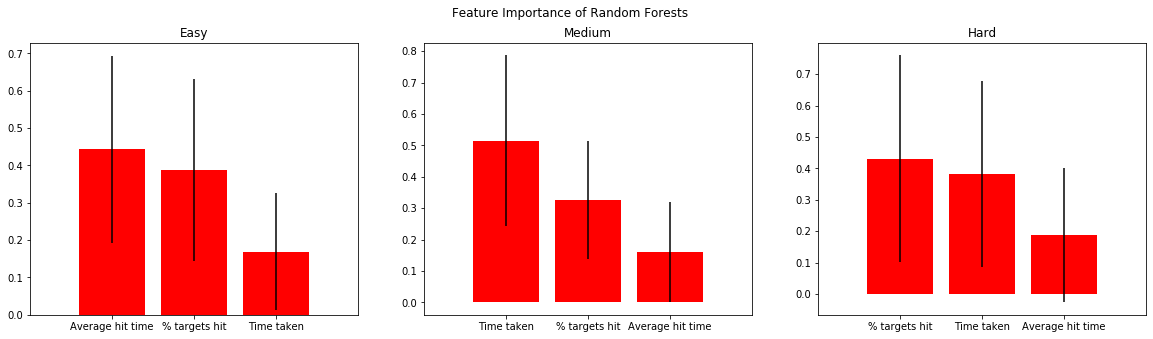

In [32]:
plot_feature_importance(clf_random_forest_easy, clf_random_forest_medium,
                        clf_random_forest_hard, 'Random Forests')

In [33]:
clf_decision_tree_easy = results['Easy']['Decision Tree'][1]
clf_decision_tree_medium = results['Medium']['Decision Tree'][1]
clf_decision_tree_hard = results['Hard']['Decision Tree'][1]

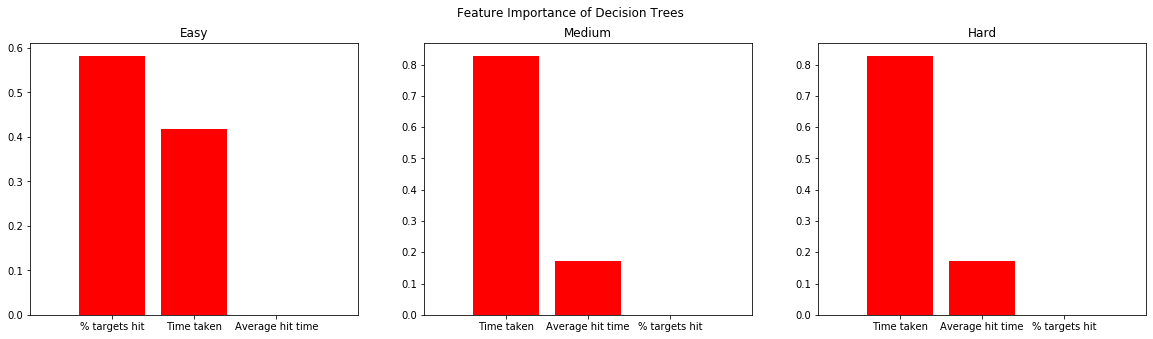

In [34]:
plot_feature_importance(clf_decision_tree_easy, clf_decision_tree_medium,
                        clf_decision_tree_hard, 'Decision Trees')

Similar to the case seen in table1, Decision Trees use fewer features. Although this may be beneficial for the training data here, we wish to create a model that is sufficiently robust to real-world patients, and takes a wider array of input variables. This is why random forests are preferred.

However, this dataset may exhibit a new feature called multicollinearity. This is where one input variable can be predicted from another very simply. The data here may exhibit this pattern, since the total time taken is associated with the average hit time (indeed, the function to calculate total time taken included a multiple of it). To see whether this negatively impacts results, we will model the data without it. First, we plot the relationship between the two inputs graphically.

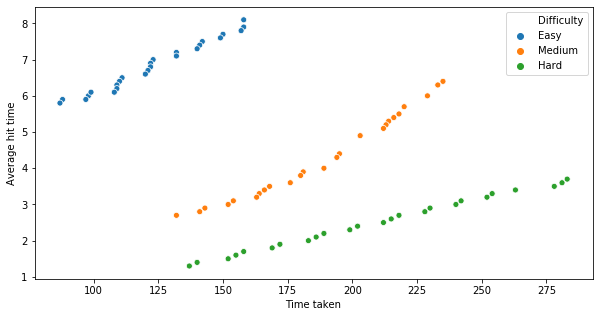

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(ax=ax, x=new['Time taken'], y=new['Average hit time'], hue=new['Difficulty'], legend='full')

There is a clear correlation between these two input variables. Removing the Average hit time column from the data we get:

In [36]:
tables = [X_train_easy, X_test_easy, X_train_medium, X_test_medium, X_train_hard, X_test_hard]
tab_simp = ['X_train_easy', 'X_test_easy', 'X_train_medium', 'X_test_medium', 'X_train_hard', 'X_test_hard']
simple_tables = {}
for i, table in enumerate(tables):
    k = tab_simp[i]
    simple_tables[k] = table.drop(columns = ['Average hit time'])

In [37]:
simple_tables['X_train_easy'].sample(5)

,Time taken,% targets hit
Patient No. (ID),,
10,132.0,0.6
8,140.0,0.5
4,150.0,0.4
24,88.0,1.0
14,121.0,0.7


And now we compare the results to that using all of the input variables.

In [38]:
diff_simple = {'Easy': [simple_tables['X_train_easy'], y_train_easy], 
        'Medium': [simple_tables['X_train_medium'], y_train_medium], 
        'Hard': [simple_tables['X_train_hard'], y_train_hard]}

In [39]:
best_classifier(diff_simple, models)

SVM on table Easy scored 1.0
Logistic on table Easy scored 1.0
LDA on table Easy scored 1.0
kNN on table Easy scored 1.0
Decision Tree on table Easy scored 1.0
Naive Bayes on table Easy scored 0.8999999999999999
Random Forest on table Easy scored 1.0
XGBoost on table Easy scored 1.0
SVM on table Medium scored 0.9
Logistic on table Medium scored 0.8500000000000001
LDA on table Medium scored 0.95
kNN on table Medium scored 0.9
Decision Tree on table Medium scored 0.9
Naive Bayes on table Medium scored 0.9
Random Forest on table Medium scored 0.95
XGBoost on table Medium scored 0.9
SVM on table Hard scored 0.95
Logistic on table Hard scored 0.9
LDA on table Hard scored 0.9
kNN on table Hard scored 0.95
Decision Tree on table Hard scored 0.8500000000000001
Naive Bayes on table Hard scored 0.8
Random Forest on table Hard scored 0.95
XGBoost on table Hard scored 0.8500000000000001


{'Easy': {'SVM': [1.0,
   SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
       decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
       max_iter=-1, probability=False, random_state=None, shrinking=True,
       tol=0.001, verbose=False)],
  'Logistic': [1.0,
   LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='warn', n_jobs=None, penalty='l1',
                      random_state=None, solver='warn', tol=0.0001, verbose=0,
                      warm_start=False)],
  'LDA': [1.0,
   LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                              solver='svd', store_covariance=False, tol=0.0001)],
  'kNN': [1.0,
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                        metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                       

In [40]:
find_average()

{'SVM': 0.9499999999999998, 'Logistic': 0.9166666666666666, 'LDA': 0.9500000000000001, 'kNN': 0.9499999999999998, 'Decision Tree': 0.9166666666666666, 'Naive Bayes': 0.8666666666666666, 'Random Forest': 0.9666666666666667, 'XGBoost': 0.9166666666666666}


Results are now slightly lower. Should run a third time.

The results are very similar. The results are, in fact, slightly lower when we remove an additional input feature. The highest performing classification algorithm, Random Forests, saw a reduction in accuracy scores. This suggests that it is not beneficial to remove the number of input features from our data, given the multicollinearity of our input features. Additionally, random forests achieve the highest accuracy scores, and consequently they are chosen to be the best classification algorithm for Table2 input data.

Next, we look at ordinal regression techniques, and apply them to the same datasets created in our three tables.

## Ordinal Regression

We start with ordinal Logistic with Immediate Thresholds.

In [41]:
import mord
from sklearn.model_selection import cross_val_score
ordinal_results = {}
for j in diff.keys():
    log = mord.LogisticIT(alpha=1.0, verbose=0)
    log.fit(diff[j][0], diff[j][1])
    scores = cross_val_score(log, diff[j][0], diff[j][1], cv=4)
    ordinal_results[j] = [scores.mean(), scores]
ordinal_results

{'Easy': [1.0, array([1., 1., 1., 1.])],
 'Medium': [0.95, array([1. , 0.8, 1. , 1. ])],
 'Hard': [0.95, array([1. , 0.8, 1. , 1. ])]}

The results are already impressive. We attempt to improve these further using GridSearchCV.

In [42]:
parameters_logIT = {'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
ordinal_results2 = {}
for j in diff.keys():
    CV = GridSearchCV(mord.LogisticIT(), parameters_logIT, cv=4, iid=False, scoring='accuracy', n_jobs=1)
    CV = CV.fit(diff[j][0], diff[j][1])
    ordinal_results2[j] = [CV.best_score_, CV.best_estimator_]
ordinal_results2

{'Easy': [1.0, LogisticIT(alpha=0.1, max_iter=1000, verbose=0)],
 'Medium': [0.95, LogisticIT(alpha=0.1, max_iter=1000, verbose=0)],
 'Hard': [0.95, LogisticIT(alpha=0.1, max_iter=1000, verbose=0)]}

In [43]:
parameters_logIT = {'alpha': [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]}
ordinal_results3 = {}
for j in diff.keys():
    CV = GridSearchCV(mord.LogisticIT(), parameters_logIT, cv=4, iid=False, scoring='accuracy', n_jobs=1)
    CV = CV.fit(diff[j][0], diff[j][1])
    ordinal_results3[j] = [CV.best_score_, CV.best_estimator_]
ordinal_results3

{'Easy': [1.0, LogisticIT(alpha=0.01, max_iter=1000, verbose=0)],
 'Medium': [0.95, LogisticIT(alpha=0.02, max_iter=1000, verbose=0)],
 'Hard': [0.95, LogisticIT(alpha=0.02, max_iter=1000, verbose=0)]}

In [44]:
def logITGird(dif):
    parameters_logIT = {'alpha': [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]}
    ordinal_results4 = {}
    for j in dif.keys():
        CV = GridSearchCV(mord.LogisticIT(), parameters_logIT, cv=4, iid=False, scoring='accuracy', n_jobs=1)
        CV = CV.fit(diff[j][0], diff[j][1])
        ordinal_results4[j] = [CV.best_score_, CV.best_estimator_]
    return ordinal_results4

In [45]:
ordinal_results4 = logITGird(diff)
ordinal_results4

{'Easy': [1.0, LogisticIT(alpha=0.001, max_iter=1000, verbose=0)],
 'Medium': [0.95, LogisticIT(alpha=0.001, max_iter=1000, verbose=0)],
 'Hard': [0.95, LogisticIT(alpha=0.001, max_iter=1000, verbose=0)]}

Running GirdSearchCV 3 times, however, did not improve the results. The mean will be taken for the three trained models.

In [46]:
def avg():
    mean = 0
    for i in ordinal_results4.keys():
        mean += ordinal_results4[i][0]
    mean /= 3
    return mean

In [47]:
avg()

0.9666666666666667

This performs very strongly, but not as high as Random Forests. We also compare the results with the simplified table, with only two input features:

In [48]:
logITGird(diff_simple)

{'Easy': [1.0, LogisticIT(alpha=0.001, max_iter=1000, verbose=0)],
 'Medium': [0.95, LogisticIT(alpha=0.001, max_iter=1000, verbose=0)],
 'Hard': [0.95, LogisticIT(alpha=0.001, max_iter=1000, verbose=0)]}

In [49]:
avg()

0.9666666666666667

The results are the same in both cases, and therefore do not perform as well as random forests. We now look at logistic ordinal regression, the all-threshold variant, for two and then three inpput features;

In [50]:
def logATGrid(dif):
    parameters_logAT = {'alpha': [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]}
    ordinal_results5 = {}
    for j in dif.keys():
        CV = GridSearchCV(mord.LogisticAT(), parameters_logAT, cv=4, iid=False, scoring='accuracy', n_jobs=1)
        CV = CV.fit(diff[j][0], diff[j][1])
        ordinal_results5[j] = [CV.best_score_, CV.best_estimator_]
    return ordinal_results5

In [51]:
ordinal_results5 = logATGrid(diff)
ordinal_results5

{'Easy': [1.0, LogisticAT(alpha=0.001, max_iter=1000, verbose=0)],
 'Medium': [0.95, LogisticAT(alpha=0.001, max_iter=1000, verbose=0)],
 'Hard': [0.95, LogisticAT(alpha=0.003, max_iter=1000, verbose=0)]}

In [52]:
def avg2():    
    mean2 = 0
    for i in ordinal_results5.keys():
        mean2 += ordinal_results5[i][0]
    mean2 /= 3
    return mean2

In [53]:
avg2()

0.9666666666666667

In [54]:
ordinal_results5 = logATGrid(diff_simple)
ordinal_results5

{'Easy': [1.0, LogisticAT(alpha=0.001, max_iter=1000, verbose=0)],
 'Medium': [0.95, LogisticAT(alpha=0.001, max_iter=1000, verbose=0)],
 'Hard': [0.95, LogisticAT(alpha=0.003, max_iter=1000, verbose=0)]}

In [55]:
avg2()

0.9666666666666667

Same as in the immediate-threshold case, for both sets of data.

## Regression

Finally, we consider regression approahces to identifying the correct class. Here, since Scikit-learn's cross_val_score does not allow us to round the values before producing an accuracy score, we create our own KFold cross-validation metric, and use this to evaluate this for the perforamnce of our regression model. We do this for our three models, for the non-simplified (three inputs) and simplified (two inputs) tables.

In [56]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
def reg(dif):
# diff = {'Easy': [X_train_easy, y_train_easy], 'Medium': [X_train_medium, y_train_easy], 'Hard': [X_train_hard, y_train_hard]}
    regression_results = {}
    fold = KFold(n_splits = 4, shuffle = True)
    for j in dif.keys():
        CV_score = []
        for i in range(4):
            split = next(fold.split(dif[j][0]), None)
            X_train_split, X_test_split, y_train_split, y_test_split = dif[j][0].iloc[split[0]], dif[j][0].iloc[split[1]], dif[j][1].iloc[split[0]], dif[j][1].iloc[split[1]]
            reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
            reg.fit(X_train_split, y_train_split)
            predictions = reg.predict(X_test_split)
            predictions = np.around(predictions, decimals=0)
            accuracy = accuracy_score(y_test_split, predictions)
            CV_score.append(accuracy)
        regression_results[j] = np.mean(CV_score)
    return regression_results

In [57]:
regression_results = reg(diff)
regression_results

{'Easy': 0.8999999999999999, 'Medium': 0.9, 'Hard': 0.8500000000000001}

In [58]:
mean = np.mean(list(regression_results.values()))
print(f'Mean result: {mean}')

Mean result: 0.8833333333333333


These are strong results. Using one less feature input improves the accuracy scores further:

In [59]:
regression_results_simple = reg(diff_simple)
regression_results_simple

{'Easy': 0.9, 'Medium': 0.9, 'Hard': 1.0}

In [60]:
mean = np.mean(list(regression_results_simple.values()))
print(f'Mean result: {mean}')

Mean result: 0.9333333333333332


These results are weaker, however, than the ordinal and classification cases. Therefore the type of model with the strongest results will be taken, and that is, again, valilla classification.

## Model Scores

In [61]:
y_pred_random_forest_easy = clf_random_forest_easy.predict(X_test_easy)
accuracy_random_forest_easy = accuracy_score(y_test_easy, y_pred_random_forest_easy)
y_pred_random_forest_medium = clf_random_forest_medium.predict(X_test_medium)
accuracy_random_forest_medium = accuracy_score(y_test_medium, y_pred_random_forest_medium)
y_pred_random_forest_hard = clf_random_forest_hard.predict(X_test_hard)
accuracy_random_forest_hard = accuracy_score(y_test_hard, y_pred_random_forest_hard)
print(f'Accuracy Score for Easy: {accuracy_random_forest_easy}')
print(f'Accuracy Score for Medium: {accuracy_random_forest_medium}')
print(f'Accuracy score for Hard: {accuracy_random_forest_hard}')

Accuracy Score for Easy: 0.8
Accuracy Score for Medium: 1.0
Accuracy score for Hard: 1.0


In [62]:
y_test_medium

Patient No. (ID)
34    2
50    5
27    1
37    3
41    4
Name: Output, dtype: int64

In [63]:
y_pred_random_forest_medium

array([2, 5, 1, 3, 4], dtype=int64)

In [64]:
def plot_confusion_matrix(y_test, y_pred, name):
    for i, title in enumerate(['Easy', 'Medium', 'Hard']):
        skplt.metrics.plot_confusion_matrix(y_test[i], y_pred[i], normalize=True, labels=[1, 2, 3, 4, 5], 
        title=f'{name} Confusion Matrix, {title}', figsize=(7,7), title_fontsize='large', cmap='Purples')
        plt.autoscale()

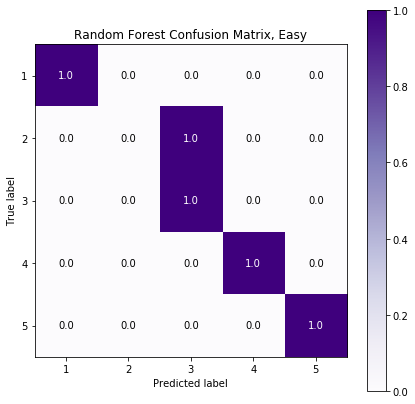

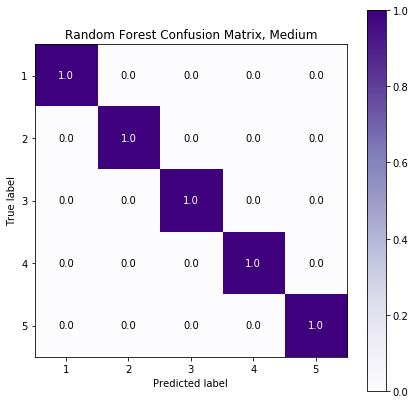

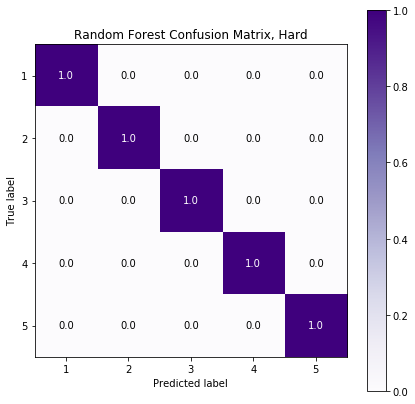

In [65]:
y_test_array = [y_test_easy, y_test_medium, y_test_hard]
y_pred_random_forest = [y_pred_random_forest_easy, y_pred_random_forest_medium, y_pred_random_forest_hard]
plot_confusion_matrix(y_test_array, y_pred_random_forest, 'Random Forest')

As you can see, the Random Forest Classifier performs incredibly well. We now save the models, to import into other Python scripts and notebooks.

In [1]:
# # Uncomment the below code to update the output model results
# import joblib
# joblib.dump(clf_random_forest_easy, 'Table2_random_forest_easy.pkl')
# joblib.dump(clf_random_forest_medium, 'Table2_random_forest_medium.pkl')
# joblib.dump(clf_random_forest_hard, 'Table2_random_forest_hard.pkl')